In [9]:
# 1. IMPORT LIBRARIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib 

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer  # <--- TAMBAHKAN BARIS INI

# Penanganan Imbalanced Data
from imblearn.over_sampling import SMOTE

# Model & Evaluasi
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score

print("Semua library berhasil di-import.")

Semua library berhasil di-import.


2. BUSINESS UNDERSTANDING (SESUAI METODOLOGI)
------------------------------------------------------------------------------
Tujuan: Membangun model machine learning untuk memprediksi apakah seorang
peminjam akan 'Fully Paid' (Lunas) atau 'Charged Off' (Gagal Bayar).
Problem: Data pinjaman secara alami tidak seimbang (imbalanced).
Solusi: Menerapkan teknik oversampling (SMOTE) untuk meningkatkan
performa model dalam mendeteksi pinjaman 'Charged Off'.

In [10]:
try:
    # Ganti dengan path file Anda
    data = pd.read_csv('loan_data_2007_2014.csv', index_col=0)
    print(f"Data berhasil dimuat. Bentuk data: {data.shape}")
except FileNotFoundError:
    print("Error: File 'loan_data_2007_2014.csv' tidak ditemukan.")
    # Keluar dari script jika data tidak ada
    exit()

C:\Users\User\AppData\Local\Temp\ipykernel_5820\2972447984.py:3: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('loan_data_2007_2014.csv', index_col=0)


Data berhasil dimuat. Bentuk data: (466285, 74)


In [11]:
print("Memulai Data Preparation...")
data['loan_status'] = data['loan_status'].map({
    'Fully Paid': 0,
    'Charged Off': 1
})

df_model = data[data['loan_status'].isin([0, 1])].copy()
df_model['loan_status'] = df_model['loan_status'].astype(int)

print(f"Data setelah difilter (Fully Paid & Charged Off): {df_model.shape}")

features = [
    'loan_amnt',         # Jumlah pinjaman
    'int_rate',          # Suku bunga
    'installment',       # Angsuran bulanan
    'grade',             # Grade pinjaman (A, B, C, dst.)
    'emp_length',        # Lama bekerja
    'home_ownership',    # Status kepemilikan rumah
    'annual_inc',        # Pendapatan tahunan
    'verification_status', # Status verifikasi
    'dti',               # Debt-to-Income Ratio
    'delinq_2yrs',       # Keterlambatan pembayaran 2 thn terakhir
    'inq_last_6mths',    # Jumlah penyelidikan 6 bln terakhir
    'open_acc',          # Jumlah akun terbuka
    'pub_rec',           # Catatan publik buruk
    'revol_util',        # Utilisasi kredit revolving
    'total_acc'          # Total akun kredit
]
target = 'loan_status'

df_model = df_model[features + [target]]
print("Feature selection selesai.")

emp_length_map = {
    '< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4,
    '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9,
    '10+ years': 10
}
df_model['emp_length'] = df_model['emp_length'].map(emp_length_map)

# 'grade' (Ordinal)
grade_map = {'A': 6, 'B': 5, 'C': 4, 'D': 3, 'E': 2, 'F': 1, 'G': 0}
df_model['grade'] = df_model['grade'].map(grade_map)

# Fitur Kategorikal Lainnya (Nominal) -> One-Hot Encoding
categorical_cols = ['home_ownership', 'verification_status']
df_model = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

print("Encoding fitur kategorikal selesai.")

numeric_cols = df_model.select_dtypes(include=np.number).columns.drop(target)

imputer_numeric = SimpleImputer(strategy='median')
df_model[numeric_cols] = imputer_numeric.fit_transform(df_model[numeric_cols])

print("Penanganan missing values selesai.")

Memulai Data Preparation...
Data setelah difilter (Fully Paid & Charged Off): (227214, 74)
Feature selection selesai.
Encoding fitur kategorikal selesai.
Penanganan missing values selesai.


5. PEMBAGIAN DATA (TRAIN-TEST SPLIT)

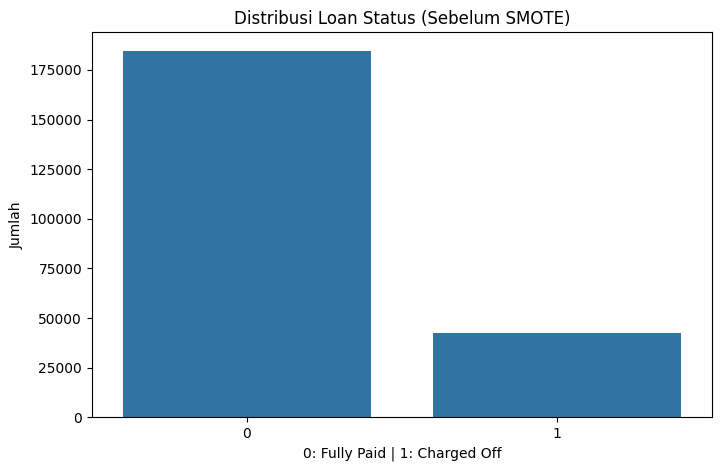

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Menampilkan visualisasi Imbalanced Data (SEBELUM SMOTE)
plt.figure(figsize=(8, 5))
sns.countplot(x='loan_status', data=df_model)
plt.title('Distribusi Loan Status (Sebelum SMOTE)')
plt.xlabel('0: Fully Paid | 1: Charged Off')
plt.ylabel('Jumlah')
plt.show()

In [13]:
X = df_model.drop(target, axis=1)
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Data berhasil dibagi (Train-Test Split).")
print(f"Bentuk X_train: {X_train.shape}")
print(f"Bentuk X_test: {X_test.shape}")

# Cek distribusi target di y_train (sebelum SMOTE)
print("\nDistribusi Target (Sebelum SMOTE):")
print(y_train.value_counts(normalize=True))



Data berhasil dibagi (Train-Test Split).
Bentuk X_train: (181771, 20)
Bentuk X_test: (45443, 20)

Distribusi Target (Sebelum SMOTE):
loan_status
0    0.813061
1    0.186939
Name: proportion, dtype: float64


 6. FEATURE SCALING
------------------------------------------------------------------------------
Scaling penting untuk banyak model, meskipun Random Forest tidak terlalu
sensitif, ini adalah 'best practice'.

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeature Scaling selesai.")



Feature Scaling selesai.


------------------------------------------------------------------------------
7. MODEL BUILDING (SEBELUM PENANGANAN IMBALANCE)
------------------------------------------------------------------------------

In [15]:
print("\nMelatih Model Baseline (Random Forest) pada data ASLI (Imbalanced)...")

rf_baseline = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_baseline.fit(X_train_scaled, y_train)

# Prediksi
y_pred_baseline = rf_baseline.predict(X_test_scaled)

print("Pelatihan Model Baseline Selesai.")



Melatih Model Baseline (Random Forest) pada data ASLI (Imbalanced)...
Pelatihan Model Baseline Selesai.


------------------------------------------------------------------------------
8. MODEL EVALUATION (SEBELUM PENANGANAN IMBALANCE)
------------------------------------------------------------------------------

In [16]:
print("\n--- HASIL EVALUASI MODEL BASELINE (SEBELUM SMOTE) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_baseline):.4f}")
print("\nClassification Report (Baseline):")
print(classification_report(y_test, y_pred_baseline, target_names=['Fully Paid (0)', 'Charged Off (1)']))
print("\nConfusion Matrix (Baseline):")
print(confusion_matrix(y_test, y_pred_baseline))


--- HASIL EVALUASI MODEL BASELINE (SEBELUM SMOTE) ---
Accuracy: 0.8126

Classification Report (Baseline):
                 precision    recall  f1-score   support

 Fully Paid (0)       0.82      0.99      0.90     36948
Charged Off (1)       0.49      0.05      0.09      8495

       accuracy                           0.81     45443
      macro avg       0.65      0.52      0.49     45443
   weighted avg       0.76      0.81      0.75     45443


Confusion Matrix (Baseline):
[[36484   464]
 [ 8054   441]]


------------------------------------------------------------------------------
9. PENANGANAN IMBALANCED DATA (SMOTE)
------------------------------------------------------------------------------

In [17]:
print("\nMelakukan Oversampling dengan SMOTE pada data training...")


smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("SMOTE Selesai.")
print("Distribusi Target (Setelah SMOTE):")
print(pd.Series(y_train_smote).value_counts(normalize=True))


Melakukan Oversampling dengan SMOTE pada data training...
SMOTE Selesai.
Distribusi Target (Setelah SMOTE):
loan_status
0    0.5
1    0.5
Name: proportion, dtype: float64


------------------------------------------------------------------------------
10. MODEL BUILDING (SETELAH PENANGANAN IMBALANCE)
------------------------------------------------------------------------------

In [19]:
print("\nMelatih Model Final (Random Forest) pada data SMOTE...")

rf_smote = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_smote.fit(X_train_smote, y_train_smote)

# Prediksi
# Model dievaluasi pada data test yang ASLI (tidak di-SMOTE)
y_pred_smote = rf_smote.predict(X_test_scaled)

print("Pelatihan Model Final Selesai.")



Melatih Model Final (Random Forest) pada data SMOTE...
Pelatihan Model Final Selesai.


------------------------------------------------------------------------------
11. MODEL EVALUATION (SETELAH PENANGANAN IMBALANCE)
------------------------------------------------------------------------------

In [20]:
print("\n--- HASIL EVALUASI MODEL FINAL (SETELAH SMOTE) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_smote):.4f}")
print("\nClassification Report (Final - SMOTE):")
print(classification_report(y_test, y_pred_smote, target_names=['Fully Paid (0)', 'Charged Off (1)']))
print("\nConfusion Matrix (Final - SMOTE):")
print(confusion_matrix(y_test, y_pred_smote))


--- HASIL EVALUASI MODEL FINAL (SETELAH SMOTE) ---
Accuracy: 0.7893

Classification Report (Final - SMOTE):
                 precision    recall  f1-score   support

 Fully Paid (0)       0.84      0.92      0.88     36948
Charged Off (1)       0.39      0.22      0.28      8495

       accuracy                           0.79     45443
      macro avg       0.61      0.57      0.58     45443
   weighted avg       0.75      0.79      0.76     45443


Confusion Matrix (Final - SMOTE):
[[34023  2925]
 [ 6648  1847]]


------------------------------------------------------------------------------
12. KESIMPULAN & DEPLOYMENT
------------------------------------------------------------------------------

In [22]:
print("\n--- KESIMPULAN PERBANDINGAN ---")
recall_baseline = recall_score(y_test, y_pred_baseline, pos_label=1)
recall_smote = recall_score(y_test, y_pred_smote, pos_label=1)

print(f"Recall 'Charged Off' (Baseline): {recall_baseline:.4f}")
print(f"Recall 'Charged Off' (SMOTE): {recall_smote:.4f}")
print(f"\nPeningkatan Recall: {((recall_smote - recall_baseline) / recall_baseline) * 100:.2f}%")
print("\nModel SMOTE menunjukkan peningkatan signifikan dalam kemampuan")
print("mendeteksi pinjaman Gagal Bayar (Charged Off), yang merupakan")
print("tujuan utama bisnis.")

try:
    joblib.dump(rf_smote, 'model_final_rf.pkl')
    joblib.dump(scaler, 'scaler_final.pkl')
    print("\nModel final (rf_smote) dan scaler berhasil disimpan ke file .pkl.")
except Exception as e:
    print(f"\nError saat menyimpan model: {e}")

print("\n=== SCRIPT SELESAI ===")



--- KESIMPULAN PERBANDINGAN ---
Recall 'Charged Off' (Baseline): 0.0519
Recall 'Charged Off' (SMOTE): 0.2174

Peningkatan Recall: 318.82%

Model SMOTE menunjukkan peningkatan signifikan dalam kemampuan
mendeteksi pinjaman Gagal Bayar (Charged Off), yang merupakan
tujuan utama bisnis.

Model final (rf_smote) dan scaler berhasil disimpan ke file .pkl.

=== SCRIPT SELESAI ===


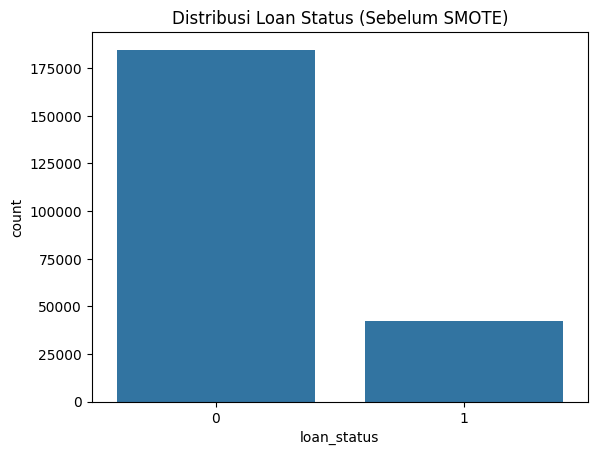

In [23]:
sns.countplot(x='loan_status', data=df_model)
plt.title('Distribusi Loan Status (Sebelum SMOTE)')
plt.show()